In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install tensorflow

In [3]:
import os
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [4]:
# Define paths
train_dir = '/content/drive/MyDrive/MAJOR PROJECT/BASE DATA/TRAIN'
val_dir = '/content/drive/MyDrive/MAJOR PROJECT/BASE DATA/VALIDATE'
test_dir = '/content/drive/MyDrive/MAJOR PROJECT/BASE DATA/TEST'
# Data Generators
train_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True, zoom_range=0.2)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Data Generators for flow_from_directory
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'  # Multi-class classification
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 786 images belonging to 2 classes.
Found 88 images belonging to 2 classes.
Found 68 images belonging to 2 classes.


In [5]:
# Load Pre-trained ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers for classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)  # Add dense layer
output_layer = Dense(2, activation='softmax')(x)  # 2 classes (ecoli, staphylococcus)

# Define final model
model = Model(inputs=base_model.input, outputs=output_layer)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 24,112,770 (91.98 MB)

 Trainable params: 525,058 (2.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [6]:
# Define callbacks
checkpoint = ModelCheckpoint(
    'resnet50_bacterial_model.keras', # Changed the file extension to .keras
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    verbose=1
)

# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=[checkpoint, early_stopping]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.7571 - loss: 0.6225
Epoch 1: val_accuracy improved from -inf to 0.43182, saving model to resnet50_bacterial_model.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 208s 8s/step - accuracy: 0.7582 - loss: 0.6199 - val_accuracy: 0.4318 - val_loss: 1.1865
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.8006 - loss: 0.4591
Epoch 2: val_accuracy did not improve from 0.43182
25/25 ━━━━━━━━━━━━━━━━━━━━ 176s 7s/step - accuracy: 0.8008 - loss: 0.4581 - val_accuracy: 0.4318 - val_loss: 0.7570
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.8003 - loss: 0.4085
Epoch 3: val_accuracy did not improve from 0.43182
25/25 ━━━━━━━━━━━━━━━━━━━━ 177s 7s/step - accuracy: 0.8005 - loss: 0.4079 - val_accuracy: 0.4318 - val_loss: 0.9769
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.8258 - loss: 0.4187
Epoch 4: val_accuracy did not improve from 0.43182
25/25 ━━━━━━━━━━━━━━━━━━━━ 174s 7s/step - accuracy: 0.8261 - loss: 

In [7]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

3/3 ━━━━━━━━━━━━━━━━━━━━ 13s 4s/step - accuracy: 0.8474 - loss: 0.3915
Test Accuracy: 88.24%


In [11]:
# Save the trained model
model.save('/content/drive/MyDrive/MAJOR PROJECT/resenet50_model.keras')

3/3 ━━━━━━━━━━━━━━━━━━━━ 13s 3s/step
Classification Report:
                precision    recall  f1-score   support

        E.COLI       1.00      0.75      0.86        32
STAPHYLOCOCCUS       0.82      1.00      0.90        36

      accuracy                           0.88        68
     macro avg       0.91      0.88      0.88        68
  weighted avg       0.90      0.88      0.88        68



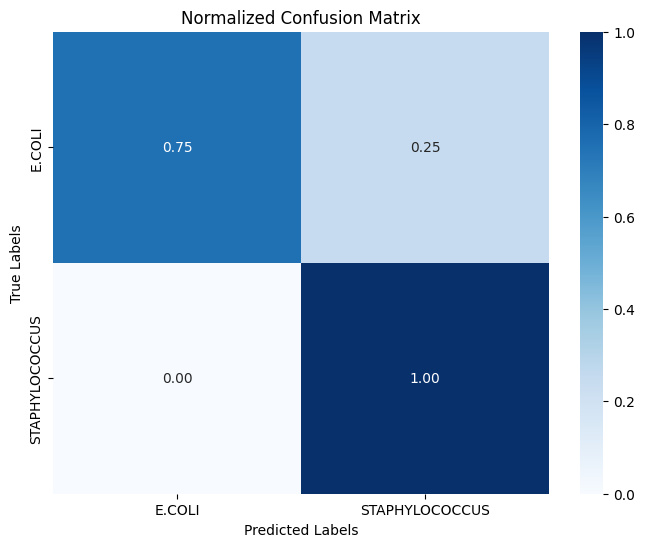

In [13]:
#Step 5: Confusion Matrix and Classification Report
!pip install matplotlib seaborn scikit-learn # install necessary packages
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np # import numpy and assign alias np

def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # Fixed: Corrected indentation

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_normalized, annot=True, cmap='Blues', fmt='.2f', xticklabels=class_names, yticklabels=class_names) # Fixed: Corrected indentation

    plt.title('Normalized Confusion Matrix') # Fixed: Corrected indentation
    plt.xlabel('Predicted Labels') # Fixed: Corrected indentation
    plt.ylabel('True Labels') # Fixed: Corrected indentation
    plt.show() # Fixed: Corrected indentation

def evaluate_model_on_test_data():
    # Generate predictions for the test set
    test_generator.reset()
    y_pred = model.predict(test_generator)
    y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class indices
    y_true = test_generator.classes  # True labels
    class_names = list(test_generator.class_indices.keys())  # Class names (e.g., 'ecoli', 'staphylococcus')

    # Print classification report
    print("Classification Report:")
    print(classification_report(y_true, y_pred_classes, target_names=class_names))

    # Plot the confusion matrix
    plot_confusion_matrix(y_true, y_pred_classes, class_names)

# Evaluate and display confusion matrix
evaluate_model_on_test_data() # Fixed: Corrected indentation to be outside function definition

Please upload an image file.


Saving synthetic_image_1.png to synthetic_image_1.png


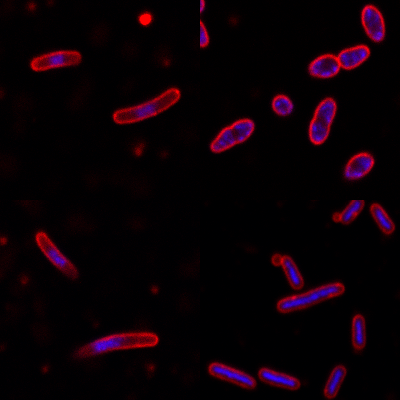

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted Label: E.COLI


In [14]:
import numpy as np
from tensorflow.keras.preprocessing import image
from google.colab import files
from IPython.display import Image, display

# Function to upload an image file and predict the bacterial type
def upload_and_predict():
    print("Please upload an image file.")

    # File upload
    uploaded = files.upload()

    for filename in uploaded.keys():
        # Display the uploaded image
        display(Image(filename=filename))

        # Load and preprocess the image
        img = image.load_img(filename, target_size=(224, 224))
        img_array = image.img_to_array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)

        # Predict the bacterial type
        prediction = model.predict(img_array)
        class_indices = {v: k for k, v in train_generator.class_indices.items()}
        predicted_class = class_indices[np.argmax(prediction)]

        print(f"Predicted Label: {predicted_class}")

    # Call the function to upload an image and predict
    #upload_and_predict() # Removing this line to avoid infinite recursion. User can manually call upload_and_predict() after this function runs.

# Call the function to initiate the prediction process
upload_and_predict()

In [15]:
import json

# Assuming you have the history object from model training
history_dict = history.history

with open("training_hist.json", "w") as f:
    json.dump(history_dict, f)
